In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def get_sub_folders(path):
    folders = []
    for folder in os.listdir(path):
        if os.path.isdir(
            os.path.join(path, folder)
        ):
            folders.append(os.path.join(path, folder))
    return folders
    
def get_results_file(path):
    for file in os.listdir(path):
        if file.endswith('results.npz'):
            return os.path.join(path, file)

In [17]:
temp = get_sub_folders('tgv_outputs')
temp

['tgv_outputs\\edac_wc',
 'tgv_outputs\\gtvf_wc',
 'tgv_outputs\\monaghan2017_wc',
 'tgv_outputs\\okra2022_wc_smag',
 'tgv_outputs\\okra2022_wc_smag_mcg',
 'tgv_outputs\\tvf_wc',
 'tgv_outputs\\wcsph_wc']

In [27]:
# Get last folder name
os.path.basename(temp[0])

'edac_wc'

In [19]:
tfile = get_results_file(temp[0])
tfile

'tgv_outputs\\edac_wc\\results.npz'

In [22]:
data = np.load(tfile)
data.files

['t', 'ke', 'ke_ex', 'decay', 'linf', 'l1', 'p_l1', 'decay_ex']

In [41]:
def plotter(parent_dir, plot_type):
    plot_types = ['decay', 'l1', 'linf', 'p_l1', 'ke']
    if plot_type not in plot_types:
        raise ValueError(
            f'Invalid plot type: {plot_type}. Valid types are: {plot_types}'
        )

    sub_folders = get_sub_folders(parent_dir)
    plot_exact = False
    plt.figure(figsize=(8, 6))
    for folder in sub_folders:
        results_file = get_results_file(folder)
        data = np.load(results_file)
        t = data['t']
        plt_label = os.path.basename(folder)
        
        if plot_type == 'decay':
            if not plot_exact:
                plt.semilogy(t, data['decay_ex'], 'k--', label='Exact')
                plot_exact = True
            plt.semilogy(t, data['decay'], label=plt_label)
        elif plot_type == 'l1':
            plt.plot(t, data['l1'], label=plt_label)
        elif plot_type == 'linf':
            plt.plot(t, data['linf'], label=plt_label)
        elif plot_type == 'p_l1':
            plt.plot(t, data['p_l1'], label=plt_label)
        elif plot_type == 'ke':
            if not plot_exact:
                plt.semilogy(t, data['ke_ex'], 'k--', label='Exact')
                plot_exact = True
            plt.plot(t, data['ke'], label=plt_label)

    plt.title(plot_type)
    plt.legend()
    plt.show()

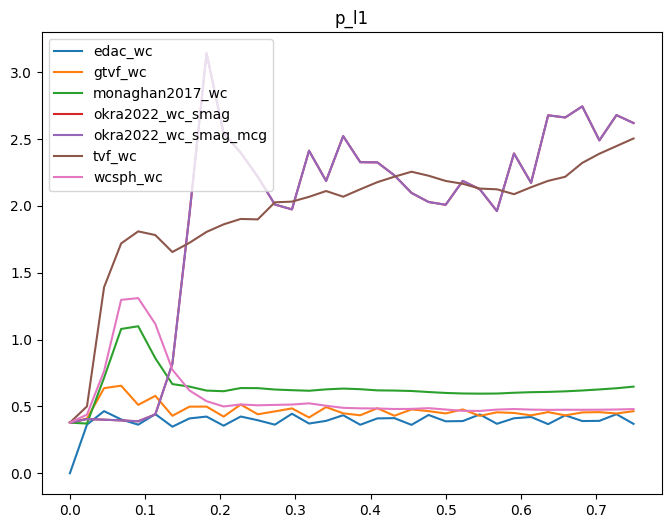

In [47]:
plotter('tgv_outputs', 'p_l1')